In [15]:
import numpy as np

# Creating Base Abstract Class

In [47]:
from abc import ABC, abstractmethod

# Abstract base class
class System(ABC):
    def __init__(self, dim_state, dim_action):
        self.dim_state = dim_state
        self.dim_action = dim_action
    
    @abstractmethod
    def get_next_state(self, state, action):
        pass

# Creating Drone and Ground Robot

In [63]:
class Drone(System):
    def __init__(self, dt, action_bounds):
        # Initialize the drone's state (position and velocity)
        super().__init__(dim_state=6, dim_action=3)  # [x, y, z, vx, vy, vz] and [ax, ay, az]
        self.action_bounds = np.array(action_bounds)
        self.dt = dt  # Time step for integration
    
    def get_next_state(self, state, action):
        """
        Action format for drone: [ax, ay, az]
        where ax, ay, az are accelerations in x, y, z directions.
        """
        # Clip action to action bounds
        action = np.clip(action, self.action_bounds[:, 0], self.action_bounds[:, 1])
        
        # Current state [x, y, z, vx, vy, vz]
        x, y, z, vx, vy, vz = state
        
        # Unpack action (accelerations in x, y, z directions)
        ax, ay, az = action
        
        # Update velocity
        vx_new = vx + ax * self.dt
        vy_new = vy + ay * self.dt
        vz_new = vz + az * self.dt
        
        # Update position
        x_new = x + vx_new * self.dt
        y_new = y + vy_new * self.dt
        z_new = z + vz_new * self.dt
        
        # Return new state
        return np.array([x_new, y_new, z_new, vx_new, vy_new, vz_new])

In [64]:
class AckermanRobot(System):
    def __init__(self, dt, action_bounds):
        # Initialize the robot's state (position and heading)
        super().__init__(dim_state=3, dim_action=2)  # [x, y, theta, v] and [steering_angle, velocity]
        self.action_bounds = np.array(action_bounds)
        self.dt = dt  # Time step for integration
        self.L = 0.5  # L is the wheelbase
    
    def get_next_state(self, state, action):
        """
        Action format for Ackerman robot: [steering_angle, velocity]
        where steering_angle is in radians and velocity is linear speed.
        """
        # Clip action to action bounds
        action = np.clip(action, self.action_bounds[:, 0], self.action_bounds[:, 1])
        
        # Current state [x, y, theta]
        x, y, theta = state
        
        # Unpack action (steering angle and velocity)
        steering_angle, velocity = action
        
        # Update velocity (just the linear speed in this model)
        v_new = velocity
        
        # Update orientation based on steering angle
        theta_new = theta + (v_new / self.L) * np.tan(steering_angle) * self.dt 
        
        # Update position based on velocity and orientation
        x_new = x + v_new * np.cos(theta_new) * self.dt
        y_new = y + v_new * np.sin(theta_new) * self.dt
        
        # Return new state
        return np.array([x_new, y_new, theta_new])

# Instantiate both Vehicles

In [77]:
drone_action_bounds = np.array([[-0.5, 0.5],  # ax bounds (m/s^2)
                                [-0.5, 0.5],  # ay bounds (m/s^2)
                                [-0.5, 0.5]]) # az bounds (m/s^2)

ackerman_action_bounds = np.array([[-np.pi/6, np.pi/6],  # steering angle bounds (radians)
                                   [0, 2]])              # velocity bounds (m/s)

# Instantiate the Drone with action bounds
drone = Drone(dt=0.1, action_bounds=drone_action_bounds)

# Instantiate the Ackerman Robot with action bounds
ackerman_robot = AckermanRobot(dt=0.1, action_bounds=ackerman_action_bounds)

# Simulation Loop

In [78]:
# Simulation parameters
simulation_time = 10  # Total simulation time in seconds
time_step_size = 0.1  # Time step size in seconds (for both systems)
num_steps = int(simulation_time / time_step_size)

# Initialize Drone state (e.g., starting at (0, 0, 5) with zero velocities)
drone_state = np.array([0.0, 0.0, 5.0, 0.0, 0.0, 0.0])  # [x, y, z, vx, vy, vz]
drone_state_history = [drone_state.copy()]
drone_action_history = []

# Initialize Ackerman Robot state (e.g., starting at (0, 0) with heading theta=0 and velocity=0)
ackerman_state = np.array([0.0, 0.0, 0.0])  # [x, y, theta, v]
ackerman_state_history = [ackerman_state.copy()]
ackerman_action_history = []

# Run the simulation loop for Drone and Ackerman Robot

for _ in range(num_steps):
    # For Drone, generate random action within bounds
    ax = np.random.uniform(drone_action_bounds[0][0], drone.action_bounds[0][1])
    ay = np.random.uniform(drone_action_bounds[1][0], drone.action_bounds[1][1])
    az = np.random.uniform(drone_action_bounds[2][0], drone.action_bounds[2][1])
    drone_action = np.array([ax,ay,az])
    # Update Drone's state using its get_next_state method
    drone_state = drone.get_next_state(drone_state, drone_action)

    # Save the current state and action for Drone
    drone_state_history.append(drone_state.copy())
    drone_action_history.append(drone_action.copy())

    # For Ackerman Robot, generate random action within bounds
    steering_angle = np.random.uniform(ackerman_action_bounds[0][0], ackerman_action_bounds[0][1])
    translation_velocity = np.random.uniform(ackerman_action_bounds[1][0], ackerman_action_bounds[1][1])
    ackerman_action = np.array([steering_angle,translation_velocity])
    # Update Ackerman Robot's state using its get_next_state method
    ackerman_state = ackerman_robot.get_next_state(ackerman_state, ackerman_action)

    # Save the current state and action for Ackerman Robot
    ackerman_state_history.append(ackerman_state.copy())
    ackerman_action_history.append(ackerman_action.copy())

# Convert histories to numpy arrays for easier analysis
drone_state_history = np.array(drone_state_history)
drone_action_history = np.array(drone_action_history)

ackerman_state_history = np.array(ackerman_state_history)
ackerman_action_history = np.array(ackerman_action_history)

# Print the final states for reference
print("Final Drone State:", drone_state)
print("Final Ackerman Robot State:", ackerman_state)



Final Drone State: [ 3.36579571  3.32954967  2.68025297  0.40431906  0.53629097 -0.50184589]
Final Ackerman Robot State: [ 8.508201   -5.58076488 -0.48570839]


# Plotting drone and ground-robot trajectories

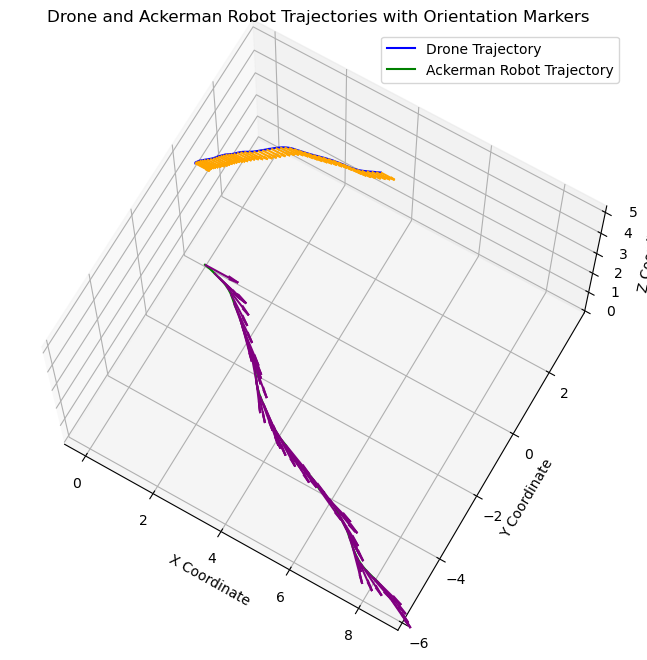

In [80]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example drone and Ackerman robot states
# Let's assume drone_state_history and ackerman_state_history are already available from the simulation

# Extract coordinates and orientations for the drone (x, y, z, and theta for 3D plot)
drone_x_coords = drone_state_history[:, 0]
drone_y_coords = drone_state_history[:, 1]
drone_z_coords = drone_state_history[:, 2]
drone_orientations = drone_state_history[:, 3]  # For drone, theta could represent yaw (heading)

# Extract coordinates and orientations for the Ackerman robot (x, y, and theta for 2D plane)
ackerman_x_coords = ackerman_state_history[:, 0]
ackerman_y_coords = ackerman_state_history[:, 1]
ackerman_theta_coords = ackerman_state_history[:, 2]  # Heading for Ackerman robot

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot drone trajectory in 3D space (x, y, z)
ax.plot(drone_x_coords, drone_y_coords, drone_z_coords, label="Drone Trajectory", alpha=1.0, color='blue')

# Plot Ackerman robot trajectory in 3D space (x, y)
ax.plot(ackerman_x_coords, ackerman_y_coords, np.zeros_like(ackerman_x_coords), label="Ackerman Robot Trajectory", alpha=1.0, color='green')

# Plot orientation arrows for drone (keep theta = 0 for arrow direction)
interval = max(1, len(drone_x_coords) // 50)  # Plot every 50th point (or fewer if necessary)
for i in range(0, len(drone_x_coords), interval):
    x = drone_x_coords[i]
    y = drone_y_coords[i]
    z = drone_z_coords[i]
    theta = 0  # Set theta = 0 for arrow direction (as requested)

    # Compute the arrow direction (we'll keep it horizontal)
    arrow_length = 0.4  # Length of the arrow representing orientation
    dx = arrow_length * np.cos(theta)
    dy = arrow_length * np.sin(theta)
    dz = 0  # No vertical movement in the arrow for orientation

    # Plot the orientation arrow for the drone
    ax.quiver(x, y, z, dx, dy, dz, color='orange', length=arrow_length, normalize=True)

# Plot orientation arrows for Ackerman robot (using theta as heading)
for i in range(0, len(ackerman_x_coords), interval):
    x = ackerman_x_coords[i]
    y = ackerman_y_coords[i]
    theta = ackerman_theta_coords[i]

    # Compute the arrow direction (we'll keep it in 2D)
    arrow_length = 1.0  # Length of the arrow representing orientation
    dx = arrow_length * np.cos(theta)
    dy = arrow_length * np.sin(theta)
    dz = 0  # For Ackerman robot, it's a 2D arrow

    # Plot the orientation arrow for the Ackerman robot
    ax.quiver(x, y, 0, dx, dy, dz, color='purple', length=arrow_length, normalize=True)

# Labels and legend
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("Drone and Ackerman Robot Trajectories with Orientation Markers")
ax.legend()

# Set view angle (elevation and azimuth)
ax.view_init(elev=70, azim=-60)  # Change this as per your desired angle

# Show grid and plot
ax.grid(True)
plt.show()